## Notebook for calculating GCB 2023 evaluation metric:
##### Southern Ocean density criterion (simplified from Bourgeois et al., 2022):

    a. Calculate average in situ density at surface between 30-55S
    b. Calculate average in situ density at 1000 m depth between 30-55S
    c. Calculate stratification index as SI = rho(1000m) - rho(surf)
    
    
Notes:

        - Calculating using gsw.rho, using depth as p, SA is g/kg (from model), CT is conservative temperature (from model)
        - calculating on model native grid, made a mask for 'SO between -55 south and -30 south'
        - calculate separately for each year and then concatenate to avoid loading multiple files into memory
        - will need to change filepaths for outputFile = f'/gpfs/data/greenocean/GCB/GCB2023/scripts/intermediateSO_SIdata/SO_SI_PlankTOM_CAL12_{simulationID}_1_gr_{yr}.nc' and make_yearlist if running in a different year
        
        
### Final data is here:

    [mep22dku@c0006 /gpfs/data/greenocean/GCB/GCB2023/submissionData2023/RIV12/Tier1/]$ ls SO_SI*
    -rw-r--r-- 1 mep22dku greenocean 18432 Jul 10 11:25 SO_SI_PlankTOM_A_1_gr_1959-2022_v20230710.nc
    -rw-r--r-- 1 mep22dku greenocean 18432 Jul 10 11:25 SO_SI_PlankTOM_B_1_gr_1959-2022_v20230710.nc
    -rw-r--r-- 1 mep22dku greenocean 18432 Jul 10 11:25 SO_SI_PlankTOM_C_1_gr_1959-2022_v20230710.nc
    -rw-r--r-- 1 mep22dku greenocean 18432 Jul 10 11:25 SO_SI_PlankTOM_D_1_gr_1959-2022_v20230710.nc

In [10]:
%reset

In [11]:
import numpy as np
from cmocean import cm
import matplotlib.pyplot as plt
import xarray as xr
import sys

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import seawater
plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 12}

plt.rc('font', **font)

In [12]:
seawater.dens

<function seawater.eos80.dens(s, t, p)>

In [13]:
import gsw

help(gsw.rho)

Help on function rho in module gsw._wrapped_ufuncs:

rho(SA, CT, p)
    Calculates in-situ density from Absolute Salinity and Conservative
    Temperature, using the computationally-efficient expression for
    specific volume in terms of SA, CT and p  (Roquet et al., 2015).
    
    Parameters
    ----------
    SA : array-like
        Absolute Salinity, g/kg
    CT : array-like
        Conservative Temperature (ITS-90), degrees C
    p : array-like
        Sea pressure (absolute pressure minus 10.1325 dbar), dbar
    
    Returns
    -------
    rho : array-like, kg/m
        in-situ density



### get cell sizes and make an SO landmask

Text(0.5, 1.0, 'cellsize mask for so (-55 to -30)')

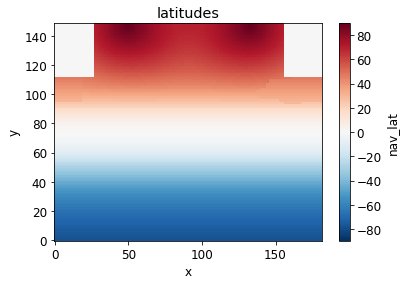

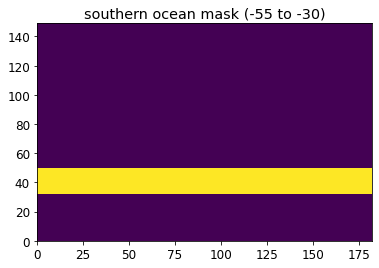

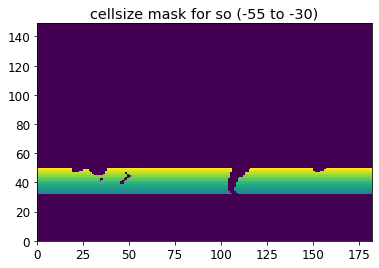

In [14]:
tmesh = xr.open_dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
tmesh['csize'] = tmesh.tmask[0,0,:,:] * tmesh.e1t[0,:,:] * tmesh.e2t[0,:,:]

tmesh.nav_lat.plot()
tmesh['csize_SO'] = tmesh.csize.copy(deep = True)
plt.title('latitudes')

so_flag = np.zeros_like(tmesh.nav_lat.values)
so_flag[(tmesh.nav_lat.values >= -55) & (tmesh.nav_lat.values <= -30)] = 1
tmesh['csize_SO'] = tmesh.csize_SO * so_flag

plt.figure()
plt.pcolormesh(so_flag)
plt.title('southern ocean mask (-55 to -30)')

plt.figure()
plt.pcolormesh(tmesh['csize_SO'])
plt.title('cellsize mask for so (-55 to -30)')


## calculate the stratification index for each year and save in `/gpfs/data/greenocean/GCB/GCB2023/scripts/intermediateSO_SIdata`

In [15]:

def make_yearlist(yrst, yrend, dtype, tr, baseDir = '/gpfs/data/greenocean/software/runs/'):
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        ty = f'{baseDir}/{tr}/ORCA2_1m_{yrs[i]}*{dtype}*.nc'
        t2 = glob.glob(ty)
        #print(t2)
        ylist.append(t2[0])
    return ylist


In [16]:
def make_intermediate_SO_SI(tmod, simulationID, yrst, yren):

    ylist = make_yearlist(yrst,yren,'grid_T', tmod )

    for i in range(0,len(ylist)):
        yr = yrst + i
        tdat = xr.open_dataset(ylist[i])
        print(yr)
        #tdatrho_surf = tmesh.csize.copy(deep = True)
        tdat = tdat.assign(rho_surf=tdat.vosaline.isel(deptht = 0))
        tdat = tdat.assign(rho_1000=tdat.vosaline.isel(deptht = 0))


        salt_surf = tdat.vosaline.isel(deptht = 0)
        temp_surf = tdat.votemper.isel(deptht = 0)
        depth_surf = np.zeros_like(temp_surf)
        depth_surf[:] = tmesh.gdept_1d[0,0].values
        rho_surf = gsw.rho(salt_surf.values, temp_surf.values, depth_surf) #calculate surface rho
        tdat['rho_surf'].values = rho_surf

        salt_1000 = tdat.vosaline.isel(deptht = 21)
        temp_1000 = tdat.votemper.isel(deptht = 21)
        depth_1000 = np.zeros_like(temp_1000)
        depth_1000[:] = tmesh.gdept_1d[0,21].values
        rho_1000 = gsw.rho(salt_1000.values, temp_1000.values, depth_1000) # calculate rho at 1000
        tdat['rho_1000'].values = rho_1000

        meanrho_surf = tdat.rho_surf.weighted(tmesh.csize_SO).mean(dim = ['x','y'])
        meanrho_1000 = tdat.rho_1000.weighted(tmesh.csize_SO).mean(dim = ['x','y'])
        meanSI = meanrho_1000-meanrho_surf
        nicetime = tdat.indexes['time_counter'].to_datetimeindex()

    #     plt.figure()
    #     plt.plot(nicetime, meanSI)
    # walrus - change this 
        outputFile = f'/gpfs/data/greenocean/GCB/GCB2024/scripts/intermediateSO_SIdata/SO_SI_PlankTOM_RIV12_{simulationID}_1_gr_{yr}.nc'
        print(f'making intermediate file {outputFile}')
        data_vars = {'SO_SI':(['TIME'], meanSI,
        {'units': 'SO_SI',
        'long_name':'Stratification index after Bourgeois 2022'}),
        }
        # define coordinates
        coords = {'TIME': (['TIME'], nicetime)}
        # define global attributes
        attrs = {'made in':'/gpfs/data/greenocean/GCB/GCB2024/scripts/makeSO_SI_RIV12.ipynb',
                 'desc':'   see GCB protocol for definition of index'
        }
        ds = xr.Dataset(data_vars=data_vars,
        coords=coords,
        attrs=attrs)
        ds.to_netcdf(outputFile)

In [17]:
runIntermediate = True
if runIntermediate:
    simulationID = 'A'
    tmod = 'TOM12_TJ_R4A0'
    yrst = 1959
    yren = 2023

    make_intermediate_SO_SI(tmod, simulationID, yrst, yren)
    
    simulationID = 'B'
    tmod = 'TOM12_TJ_R4B0'
    make_intermediate_SO_SI(tmod, simulationID, yrst, yren)

    simulationID = 'C'
    tmod = 'TOM12_TJ_R4C0'
    make_intermediate_SO_SI(tmod, simulationID, yrst, yren)

    simulationID = 'D'
    tmod = 'TOM12_TJ_R4D0'
    make_intermediate_SO_SI(tmod, simulationID, yrst, yren)

1959
making intermediate file /gpfs/data/greenocean/GCB/GCB2024/scripts/intermediateSO_SIdata/SO_SI_PlankTOM_RIV12_A_1_gr_1959.nc
1960
making intermediate file /gpfs/data/greenocean/GCB/GCB2024/scripts/intermediateSO_SIdata/SO_SI_PlankTOM_RIV12_A_1_gr_1960.nc
1961
making intermediate file /gpfs/data/greenocean/GCB/GCB2024/scripts/intermediateSO_SIdata/SO_SI_PlankTOM_RIV12_A_1_gr_1961.nc
1962
making intermediate file /gpfs/data/greenocean/GCB/GCB2024/scripts/intermediateSO_SIdata/SO_SI_PlankTOM_RIV12_A_1_gr_1962.nc
1963
making intermediate file /gpfs/data/greenocean/GCB/GCB2024/scripts/intermediateSO_SIdata/SO_SI_PlankTOM_RIV12_A_1_gr_1963.nc
1964
making intermediate file /gpfs/data/greenocean/GCB/GCB2024/scripts/intermediateSO_SIdata/SO_SI_PlankTOM_RIV12_A_1_gr_1964.nc
1965
making intermediate file /gpfs/data/greenocean/GCB/GCB2024/scripts/intermediateSO_SIdata/SO_SI_PlankTOM_RIV12_A_1_gr_1965.nc
1966
making intermediate file /gpfs/data/greenocean/GCB/GCB2024/scripts/intermediateSO_SId

### concatenate years to get the final file

In [18]:
def make_yearlist_intSO_SI(yrst, yrend, tr):
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        ty = f'/gpfs/data/greenocean/GCB/GCB2024/scripts/intermediateSO_SIdata/SO_SI_PlankTOM_RIV12_{tr}_1_gr_{yrs[i]}.nc'
        t2 = glob.glob(ty)
        #print(t2)
        ylist.append(t2[0])
    return ylist


ylist_A = make_yearlist_intSO_SI(1959,2023,'A')
so_A = xr.open_mfdataset(ylist_A)
ylist_B = make_yearlist_intSO_SI(1959,2023,'B')
so_B = xr.open_mfdataset(ylist_B)
ylist_C = make_yearlist_intSO_SI(1959,2023,'C')
so_C = xr.open_mfdataset(ylist_C)
ylist_D = make_yearlist_intSO_SI(1959,2023,'D')
so_D = xr.open_mfdataset(ylist_D)

In [20]:
import arrow

def make_so_si_nc(nicetime, tdat, simulationID, yrFrom = 1959, yrTo = 2023):

    utc = arrow.utcnow()
    timestamp = utc.format('YYYYMMDD')
    resultsdir = '/gpfs/data/greenocean/GCB/GCB2024/submissionData2024/RIV12_R4A-D0/Tier1/'
    parm = 'SO_SI'
    outputFile = f'{resultsdir}{parm}_PlankTOM_{simulationID}_1_gr_{yrFrom}-{yrTo}_v{timestamp}.nc'
    data_vars = {'SO_SI':(['TIME'], tdat,
    {'units': 'kg/m3',
    'long_name':'Stratification index after Bourgeois 2022'}),
    }
    # define coordinates
    coords = {'TIME': (['TIME'], nicetime)}
    # define global attributes
    attrs = {'made in':'/gpfs/data/greenocean/GCB/GCB2024/scripts/makeSO_SI_RIV12.ipynb',
    }
    ds = xr.Dataset(data_vars=data_vars,
    coords=coords,
    attrs=attrs)
    ds.to_netcdf(outputFile)
    
makeFinalFiles = True
if makeFinalFiles:
    make_so_si_nc(so_A.TIME, so_A.SO_SI, 'A')
    make_so_si_nc(so_B.TIME, so_B.SO_SI, 'B')
    make_so_si_nc(so_C.TIME, so_C.SO_SI, 'C')
    make_so_si_nc(so_D.TIME, so_D.SO_SI, 'D')

## check that plotted values make sense!

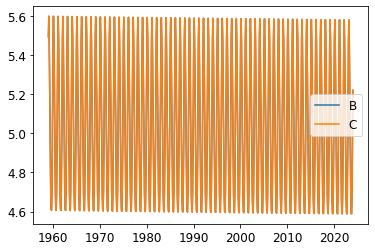

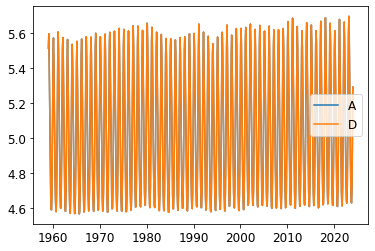

In [21]:

w = xr.open_dataset(glob.glob('//gpfs/data/greenocean/GCB/GCB2024/submissionData2024/RIV12_R4A-D0/Tier1/SO_SI_PlankTOM_A_1_gr_1959-2023_*.nc')[0])
w2 = xr.open_dataset(glob.glob('//gpfs/data/greenocean/GCB/GCB2024/submissionData2024/RIV12_R4A-D0/Tier1//SO_SI_PlankTOM_B_1_gr_1959-2023_*.nc')[0])
w3 = xr.open_dataset(glob.glob('//gpfs/data/greenocean/GCB/GCB2024/submissionData2024/RIV12_R4A-D0/Tier1//SO_SI_PlankTOM_C_1_gr_1959-2023_*.nc')[0])
w4 = xr.open_dataset(glob.glob('//gpfs/data/greenocean/GCB/GCB2024/submissionData2024/RIV12_R4A-D0/Tier1//SO_SI_PlankTOM_D_1_gr_1959-2023_*.nc')[0])

plt.figure()
#plt.plot(w.TIME, w.SO_SI, label = 'A')
plt.plot(w.TIME, w2.SO_SI, label = 'B')
plt.plot(w.TIME, w3.SO_SI, label = 'C')
#plt.plot(w.TIME, w4.SO_SI, label = 'D')
plt.legend()


plt.figure()
plt.plot(w.TIME, w.SO_SI, label = 'A')
#plt.plot(w.TIME, w2.SO_SI, label = 'B')
#plt.plot(w.TIME, w3.SO_SI, label = 'C')
plt.plot(w.TIME, w4.SO_SI, label = 'D')
plt.legend()